In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
from pathlib import Path

directory = Path.cwd()/r'OneDrive\Desktop\Datasets\dailydelhiclimate'

train_path = directory/'DailyDelhiClimateTrain.csv'
test_path = directory/'DailyDelhiCLimateTest.csv'

In [2]:
tfd = tfp.distributions
tfpl = tfp.layers

In [3]:
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

print('Training Data:')
display(train_data.head())
print('\nTest Data:')
display(test_data.head())

Training Data:


,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000



Test Data:


,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


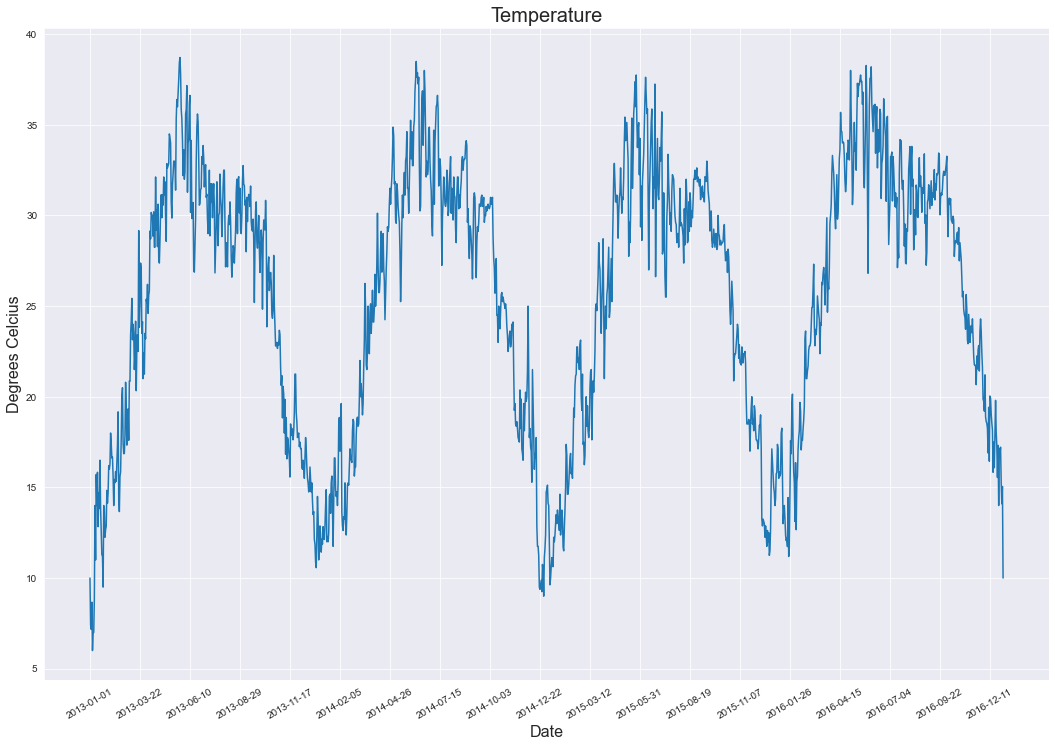

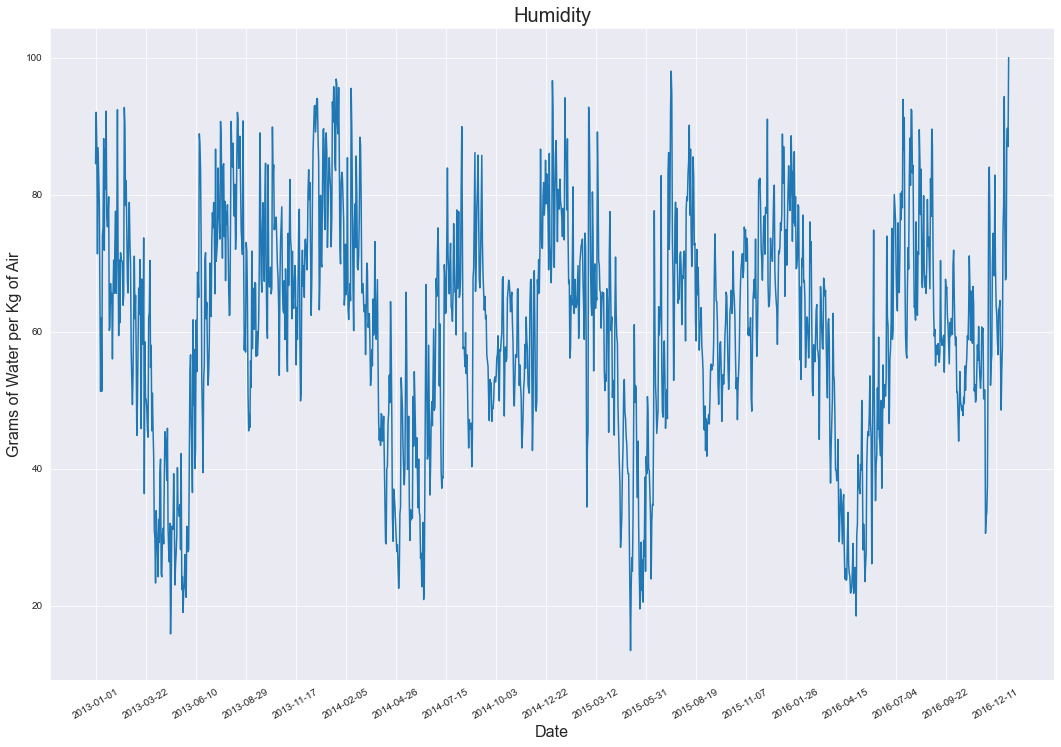

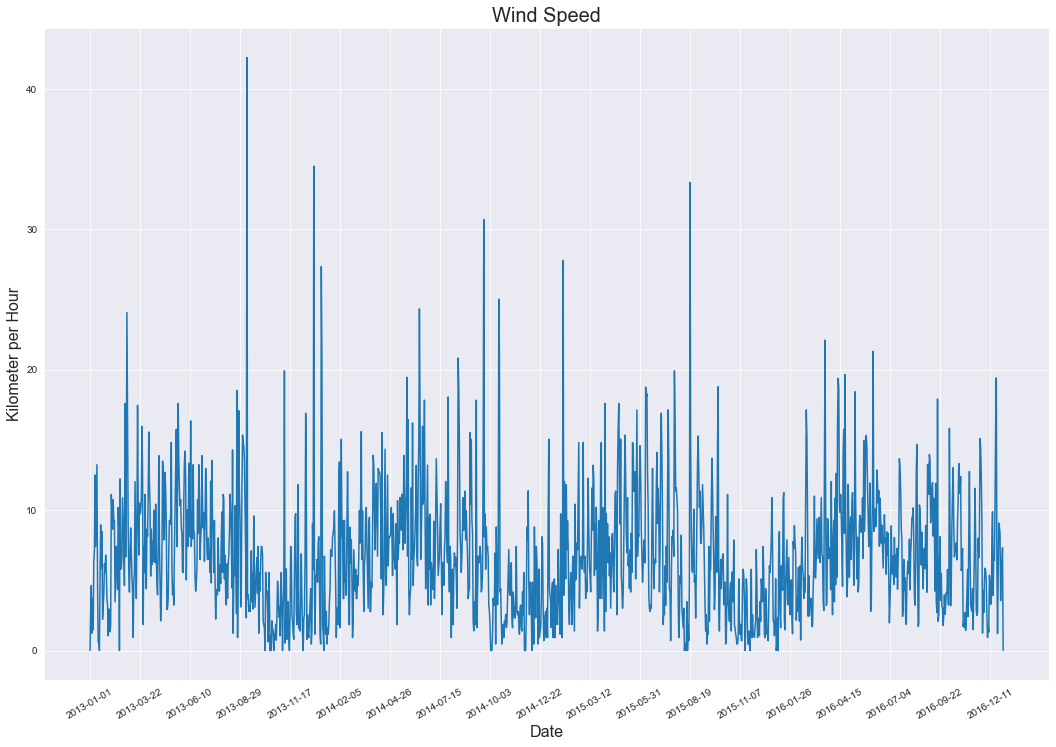

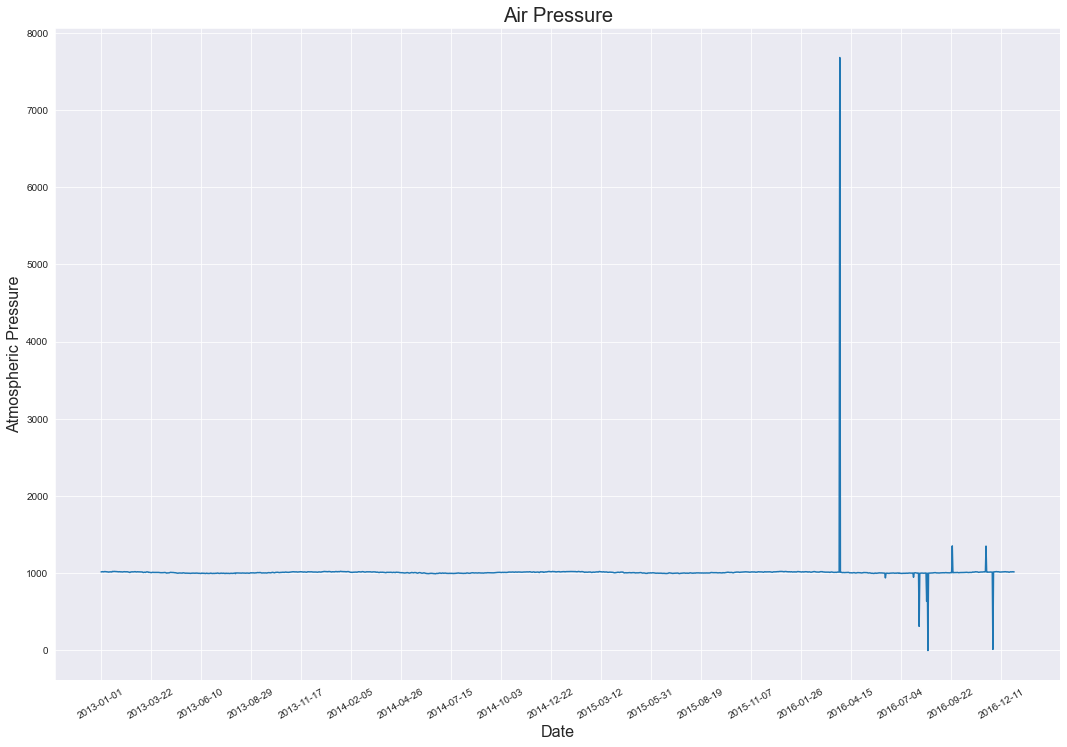

In [4]:
idx = np.array(train_data.index)
idx = train_data['date'][idx%80==0]
figsize=(18,12)
sns.set_style('darkgrid')

plt.figure(figsize=figsize)
sns.lineplot(data=train_data,x='date',y='meantemp')
plt.xlabel('Date',fontdict={'fontsize':16})
plt.title('Temperature',fontdict={'fontsize':20})
plt.ylabel('Degrees Celcius',fontdict={'fontsize':16})
plt.xticks(idx,rotation=30)
plt.show()

plt.figure(figsize=figsize)
sns.lineplot(data=train_data,x='date',y='humidity')
plt.xlabel('Date',fontdict={'fontsize':16})
plt.title('Humidity',fontdict={'fontsize':20})
plt.ylabel('Grams of Water per Kg of Air',fontdict={'fontsize':16})
plt.xticks(idx,rotation=30)
plt.show()

plt.figure(figsize=figsize)
sns.lineplot(data=train_data,x='date',y='wind_speed')
plt.xlabel('Date',fontdict={'fontsize':16})
plt.title('Wind Speed',fontdict={'fontsize':20})
plt.ylabel('Kilometer per Hour',fontdict={'fontsize':16})
plt.xticks(idx,rotation=30)
plt.show()

plt.figure(figsize=figsize)
sns.lineplot(data=train_data,x='date',y='meanpressure')
plt.xlabel('Date',fontdict={'fontsize':16})
plt.title('Air Pressure',fontdict={'fontsize':20})
plt.ylabel('Atmospheric Pressure',fontdict={'fontsize':16})
plt.xticks(idx,rotation=30)
plt.show()

In [5]:
def make_dataset(dataframe,column,window_size,drop_remainder=False,batch_size=17,prefetch_size=64):

    dataset = tf.data.Dataset.from_tensor_slices(dataframe[column])
    dataset = dataset.window(window_size,
                            shift=1,
                            stride=1,
                            drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    dataset = dataset.map(lambda window: (window[:-1],window[-1]))
    dataset = dataset.batch(batch_size,
                           drop_remainder=drop_remainder)
    dataset = dataset.prefetch(prefetch_size)
    
    return dataset

def negative_log_likelihood(y_true,y_pred):
    return -y_pred.log_prob(y_true)

In [6]:
temp_window_size = 31

train_temp = make_dataset(train_data,'meantemp',temp_window_size)
test_temp = make_dataset(test_data,'meantemp',temp_window_size)

In [7]:
l1 = keras.regularizers.L1(.8)
l2 = keras.regularizers.L2(.8)

temperature_model = keras.Sequential([
    keras.layers.Lambda(lambda sequence: tf.expand_dims(sequence,axis=-1),input_shape=(temp_window_size-1,)),
    keras.layers.SimpleRNN(150,return_sequences=True,kernel_regularizer=l1,activation='elu'),
    keras.layers.SimpleRNN(150,return_sequences=True,kernel_regularizer=l2,activation='elu'),
    keras.layers.SimpleRNN(150,kernel_regularizer=l2,activation='relu'),
    keras.layers.Lambda(lambda t: t*2),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.Adam(learning_rate=.1)

temperature_model.compile(loss='mse',
                         metrics=['mae'],
                         optimizer='adagrad')

temperature_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 30, 1)             0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 30, 150)           22800     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 30, 150)           45150     
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 150)               45150     
_________________________________________________________________
lambda_1 (Lambda)            (None, 150)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
Total params: 113,251
Trainable params: 113,251
Non-trainable params: 0
__________________________________________________

In [8]:
epochs = 50

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='mae',
                                             patience=7,
                                             factor=.1,
                                             min_delta=.03,
                                             min_lr=1e-5)

temperature_history = temperature_model.fit(train_temp,
                                           validation_data=test_temp,
                                           verbose=False,
                                           epochs=epochs,
                                           callbacks=[reduce_lr])
temp_hist = temperature_history.history

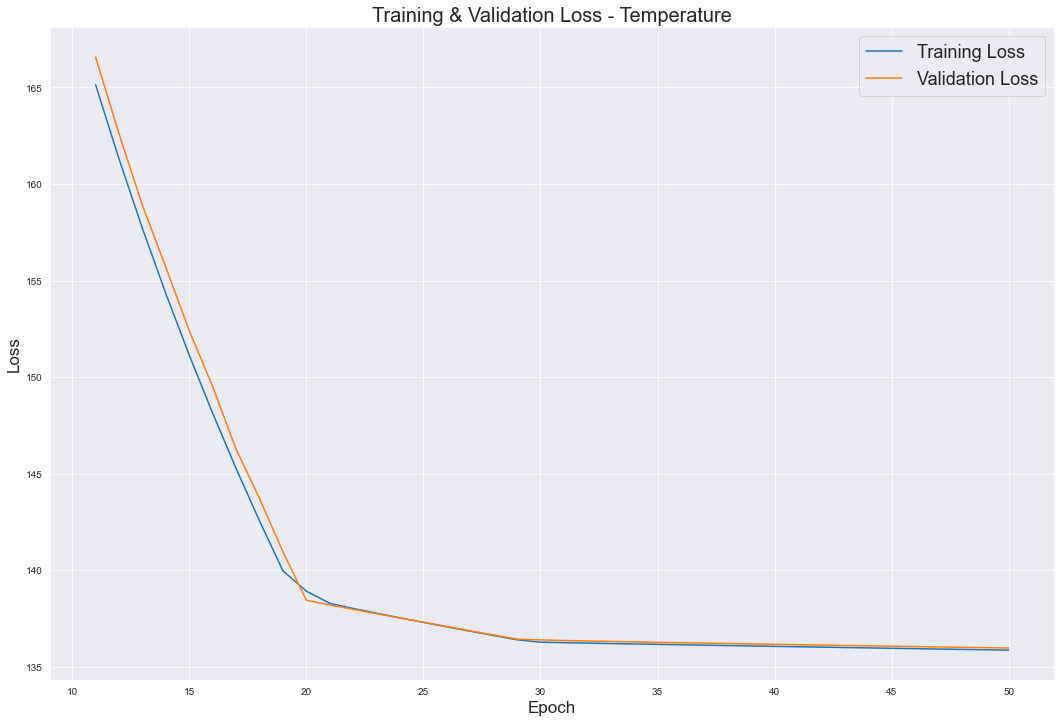

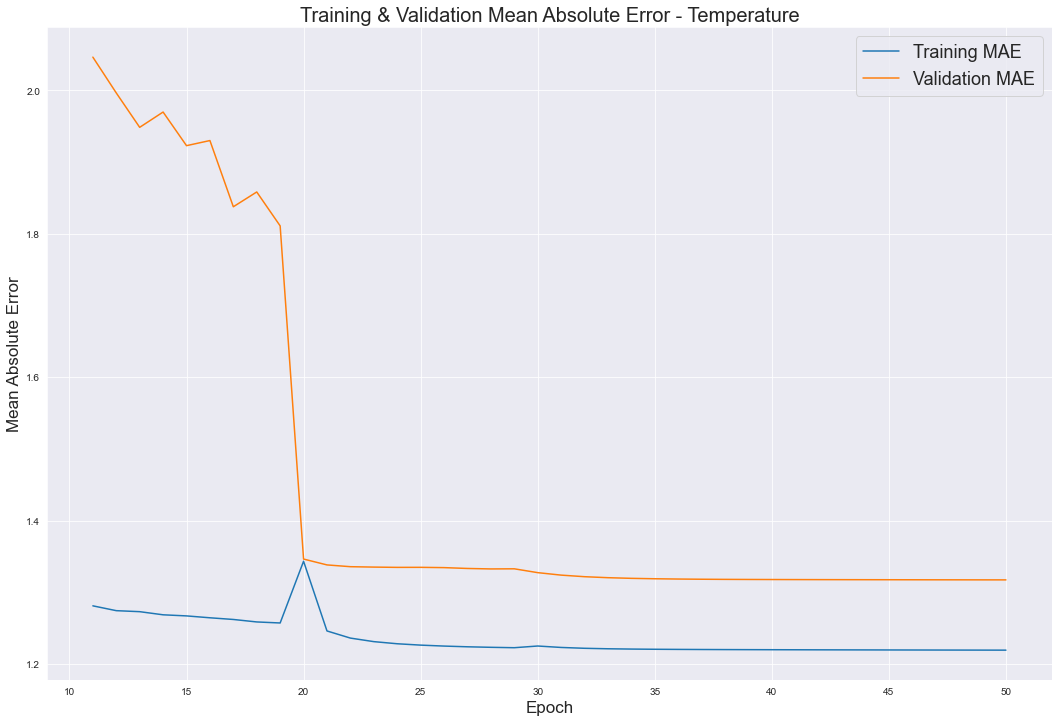

Final mean absolute error on training data:  1.219

Final mean absolute error on testing data:  1.317


In [9]:
start_point = 10

temp_loss = temp_hist['loss'][start_point:]
temp_mae = temp_hist['mae'][start_point:]

val_temp_loss = temp_hist['val_loss'][start_point:]
val_temp_mae = temp_hist['val_mae'][start_point:]

epoch = np.arange(1,epochs+1,1)[start_point:]

final_temp_mae = round(temp_mae[-1],3)
final_val_temp_mae = round(val_temp_mae[-1],3)

plt.figure(figsize=figsize)
plt.plot(epoch,temp_loss)
plt.plot(epoch,val_temp_loss)
plt.title('Training & Validation Loss - Temperature',fontdict={'fontsize':20})
plt.xlabel('Epoch',fontdict={'fontsize':17})
plt.ylabel('Loss',fontdict={'fontsize':17})
plt.legend(['Training Loss','Validation Loss'],prop={'size':18})
plt.show()

plt.figure(figsize=figsize)
plt.plot(epoch,temp_mae)
plt.plot(epoch,val_temp_mae)
plt.title('Training & Validation Mean Absolute Error - Temperature',fontdict={'fontsize':20})
plt.xlabel('Epoch',fontdict={'fontsize':17})
plt.ylabel('Mean Absolute Error',fontdict={'fontsize':17})
plt.legend(['Training MAE','Validation MAE'],prop={'size':18})
plt.show()

print('Final mean absolute error on training data: ',final_temp_mae)
print('\nFinal mean absolute error on testing data: ',final_val_temp_mae)

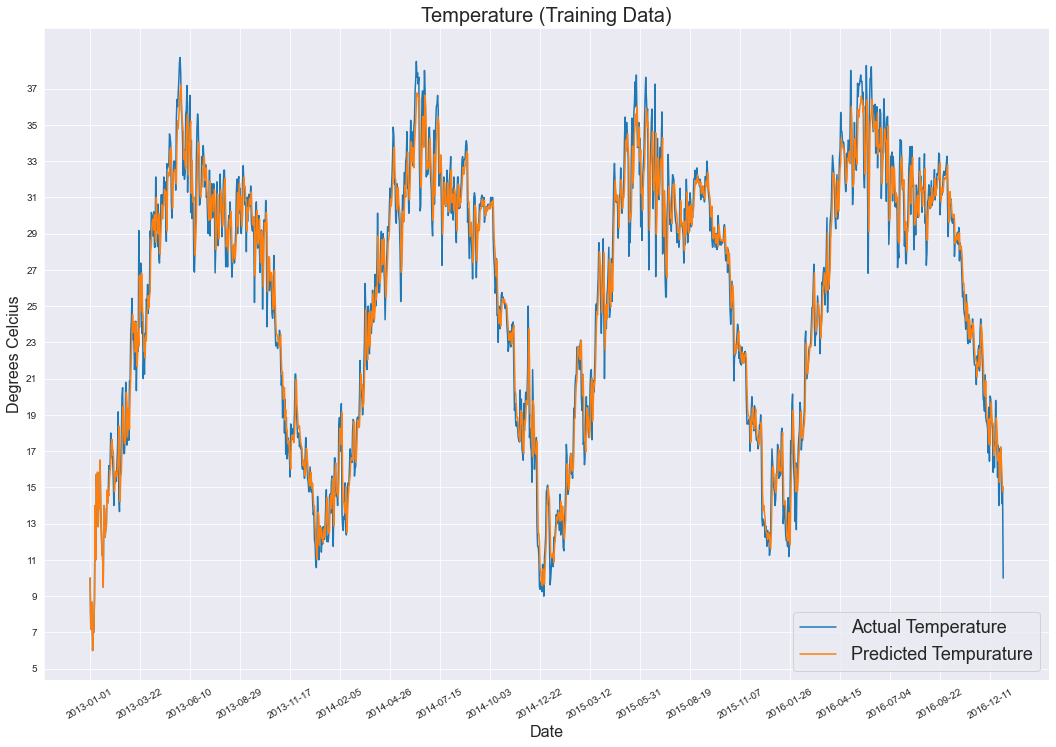

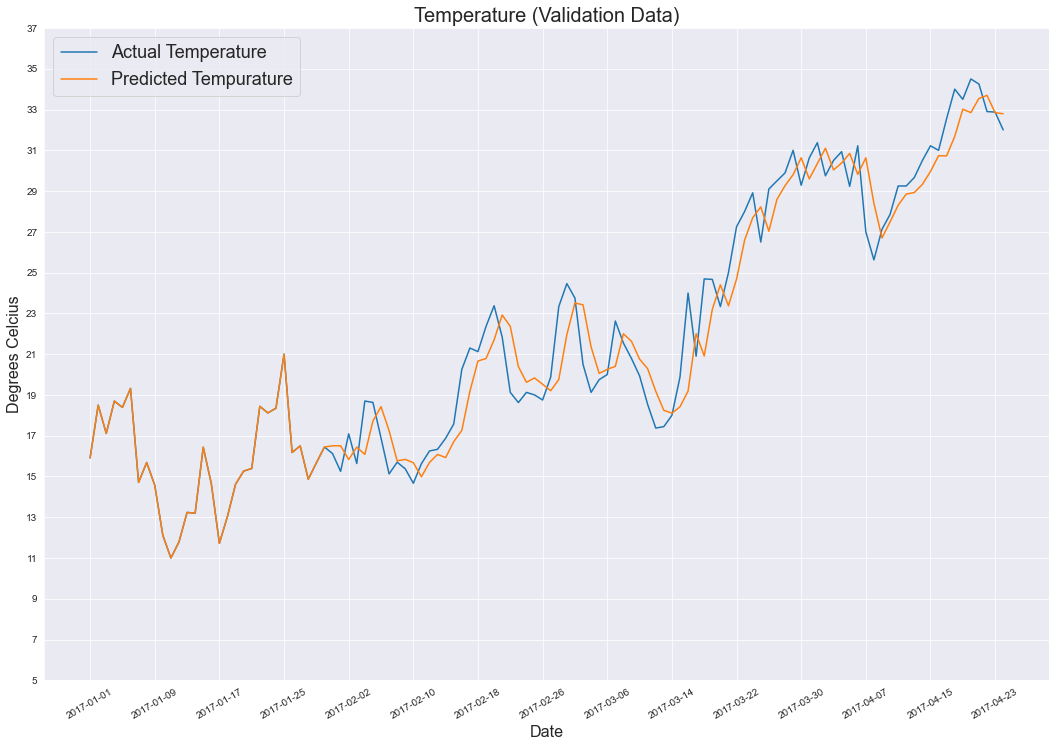

In [10]:
train_temp_predictions = temperature_model.predict(train_temp)
train_temp_predictions = np.hstack([train_data['meantemp'][:temp_window_size-1],train_temp_predictions.squeeze()])

test_temp_predictions = temperature_model.predict(test_temp)
test_temp_predictions = np.hstack([test_data['meantemp'][:temp_window_size-1],test_temp_predictions.squeeze()])

test_idx = np.array(test_data.index)
test_idx = test_data['date'][test_idx%8==0]

plt.figure(figsize=figsize)
sns.lineplot(data=train_data,x='date',y='meantemp')
sns.lineplot(x=train_data['date'],y=train_temp_predictions)
plt.xlabel('Date',fontdict={'fontsize':16})
plt.title('Temperature (Training Data)',fontdict={'fontsize':20})
plt.ylabel('Degrees Celcius',fontdict={'fontsize':16})
plt.legend(['Actual Temperature','Predicted Tempurature'],prop={'size':18})
plt.xticks(idx,rotation=30)
plt.yticks(np.arange(5,38,2))
plt.show()

plt.figure(figsize=figsize)
sns.lineplot(data=test_data,x='date',y='meantemp')
sns.lineplot(x=test_data['date'],y=test_temp_predictions)
plt.xlabel('Date',fontdict={'fontsize':16})
plt.title('Temperature (Validation Data)',fontdict={'fontsize':20})
plt.ylabel('Degrees Celcius',fontdict={'fontsize':16})
plt.legend(['Actual Temperature','Predicted Tempurature'],prop={'size':18})
plt.xticks(test_idx,rotation=30)
plt.yticks(np.arange(5,38,2))
plt.show()

In [11]:
humidity_window_size = 26

train_humidity = make_dataset(train_data,'humidity',humidity_window_size)
test_humidity = make_dataset(test_data,'humidity',humidity_window_size)

In [12]:
humidity_model = keras.Sequential([
    keras.layers.Lambda(lambda sequence: tf.expand_dims(sequence,axis=-1),input_shape=(humidity_window_size-1,)),
    keras.layers.GRU(100,return_sequences=True,activation='elu'),
    keras.layers.GRU(100,return_sequences=True,activation='elu'),
    keras.layers.SimpleRNN(100,activation='relu',return_sequences=True),
    keras.layers.SimpleRNN(100,activation='relu'),
    keras.layers.Dense(tfpl.IndependentNormal.params_size(1)),
    tfpl.IndependentNormal(event_shape=1,
                          convert_to_tensor_fn=tfd.Distribution.sample)
])

optimizer = keras.optimizers.Adagrad(learning_rate=.01)

humidity_model.compile(loss=negative_log_likelihood,
                      optimizer=optimizer,
                      metrics=['mae'])

humidity_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 25, 1)             0         
_________________________________________________________________
gru (GRU)                    (None, 25, 100)           30900     
_________________________________________________________________
gru_1 (GRU)                  (None, 25, 100)           60600     
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 25, 100)           20100     
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 100)               20100     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
_________________________________________________________________
independent_normal (Independ multiple                 

In [13]:
epochs = 100

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='mae',
                                             patience=10,
                                             factor=.1,
                                             min_delta=.03,
                                             min_lr=1e-4)

humidity_history = humidity_model.fit(train_humidity,
                                     validation_data=test_humidity,
                                     verbose=False,
                                     epochs=epochs,
                                     callbacks=[reduce_lr])
humidity_hist = humidity_history.history

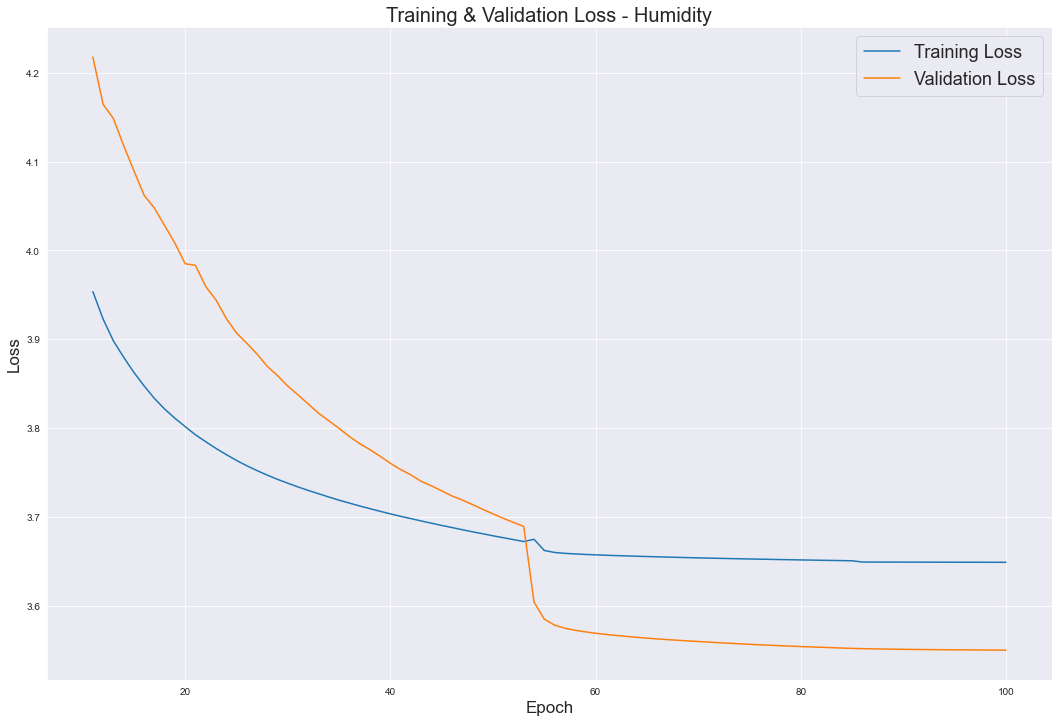

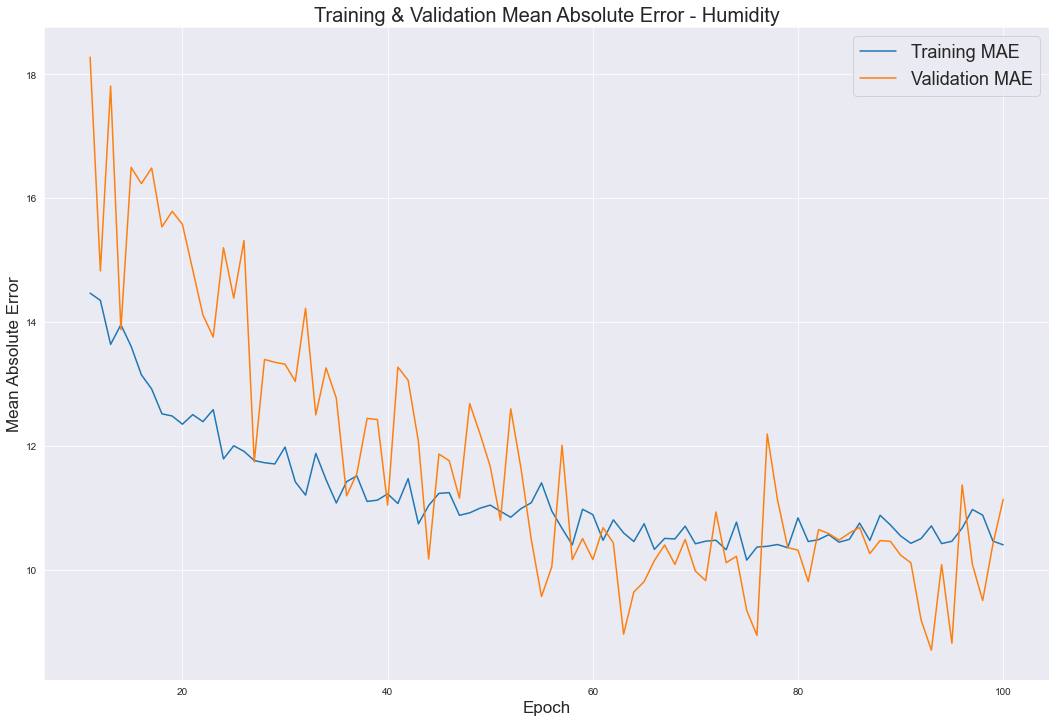

Final mean absolute error on training data:  10.4

Final mean absolute error on testing data:  11.136


In [14]:
start_point = 10

humidity_loss = humidity_hist['loss'][start_point:]
humidity_mae = humidity_hist['mae'][start_point:]

val_humidity_loss = humidity_hist['val_loss'][start_point:]
val_humidity_mae = humidity_hist['val_mae'][start_point:]

epoch = np.arange(1,epochs+1,1)[start_point:]

final_humidity_mae = round(humidity_mae[-1],3)
final_val_humidity_mae = round(val_humidity_mae[-1],3)

plt.figure(figsize=figsize)
plt.plot(epoch,humidity_loss)
plt.plot(epoch,val_humidity_loss)
plt.title('Training & Validation Loss - Humidity',fontdict={'fontsize':20})
plt.xlabel('Epoch',fontdict={'fontsize':17})
plt.ylabel('Loss',fontdict={'fontsize':17})
plt.legend(['Training Loss','Validation Loss'],prop={'size':18})
plt.show()

plt.figure(figsize=figsize)
plt.plot(epoch,humidity_mae)
plt.plot(epoch,val_humidity_mae)
plt.title('Training & Validation Mean Absolute Error - Humidity',fontdict={'fontsize':20})
plt.xlabel('Epoch',fontdict={'fontsize':17})
plt.ylabel('Mean Absolute Error',fontdict={'fontsize':17})
plt.legend(['Training MAE','Validation MAE'],prop={'size':18})
plt.show()

print('Final mean absolute error on training data: ',final_humidity_mae)
print('\nFinal mean absolute error on testing data: ',final_val_humidity_mae)

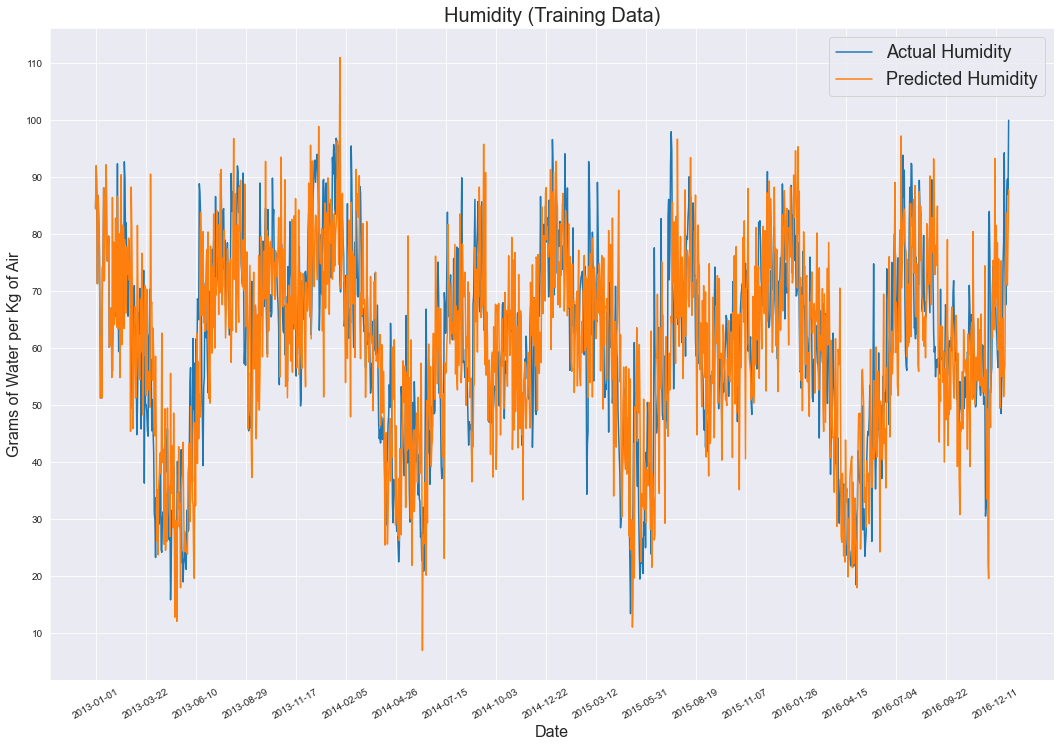

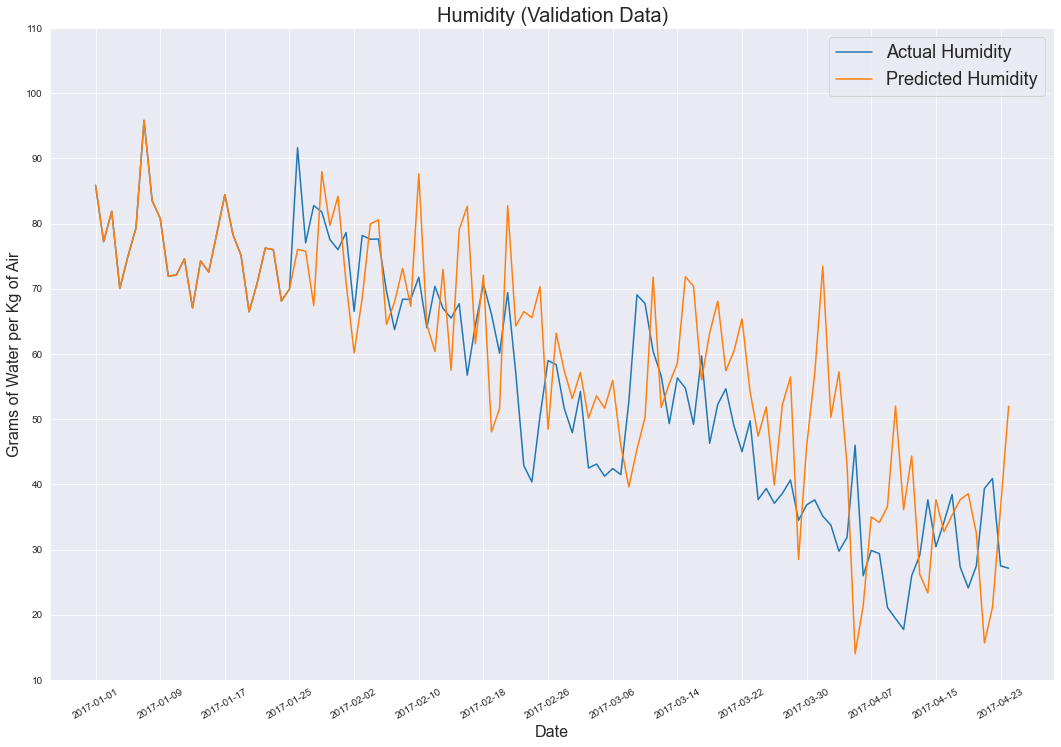

In [15]:
train_humidity_predictions = humidity_model.predict(train_humidity)
train_humidity_predictions = np.hstack([train_data['humidity'][:humidity_window_size-1],
                                        train_humidity_predictions.squeeze()])

test_humidity_predictions = humidity_model.predict(test_humidity)
test_humidity_predictions = np.hstack([test_data['humidity'][:humidity_window_size-1],
                                       test_humidity_predictions.squeeze()])

test_idx = np.array(test_data.index)
test_idx = test_data['date'][test_idx%8==0]

plt.figure(figsize=figsize)
sns.lineplot(data=train_data,x='date',y='humidity')
sns.lineplot(x=train_data['date'],y=train_humidity_predictions)
plt.xlabel('Date',fontdict={'fontsize':16})
plt.title('Humidity (Training Data)',fontdict={'fontsize':20})
plt.ylabel('Grams of Water per Kg of Air',fontdict={'fontsize':16})
plt.legend(['Actual Humidity','Predicted Humidity'],prop={'size':18})
plt.xticks(idx,rotation=30)
plt.yticks(np.arange(10,120,10))
plt.show()

plt.figure(figsize=figsize)
sns.lineplot(data=test_data,x='date',y='humidity')
sns.lineplot(x=test_data['date'],y=test_humidity_predictions)
plt.xlabel('Date',fontdict={'fontsize':16})
plt.title('Humidity (Validation Data)',fontdict={'fontsize':20})
plt.ylabel('Grams of Water per Kg of Air',fontdict={'fontsize':16})
plt.legend(['Actual Humidity','Predicted Humidity'],prop={'size':18})
plt.xticks(test_idx,rotation=30)
plt.yticks(np.arange(10,120,10))
plt.show()

In [16]:
windspeed_window_size = 36

train_wind_speed = make_dataset(train_data,'wind_speed',windspeed_window_size)
test_wind_speed = make_dataset(test_data,'wind_speed',windspeed_window_size)

In [17]:
wind_model = keras.Sequential([
    keras.layers.Lambda(lambda sequence: tf.expand_dims(sequence,axis=-1),input_shape=(windspeed_window_size-1,)),
    keras.layers.LSTM(150,return_sequences=True,activation='elu'),
    keras.layers.LSTM(150,return_sequences=True,activation='elu'),
    keras.layers.LSTM(150,activation='relu'),
    keras.layers.Dense(tfpl.IndependentNormal.params_size(1)),
    tfpl.IndependentNormal(1,
                          convert_to_tensor_fn=tfd.Distribution.sample)
])

optimizer = keras.optimizers.Adagrad(learning_rate=.002)

wind_model.compile(loss=negative_log_likelihood,
                  optimizer=optimizer,
                  metrics=['mae'])

wind_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 35, 1)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 35, 150)           91200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 35, 150)           180600    
_________________________________________________________________
lstm_2 (LSTM)                (None, 150)               180600    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 302       
_________________________________________________________________
independent_normal_1 (Indepe multiple                  0         
Total params: 452,702
Trainable params: 452,702
Non-trainable params: 0
________________________________________________

In [18]:
epochs = 40

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='mae',
                                             patience=10,
                                             factor=.1,
                                             min_delta=.03,
                                             min_lr=1e-4)

wind_history = wind_model.fit(train_wind_speed,
                             validation_data=test_wind_speed,
                             epochs=epochs,
                             verbose=False,
                             callbacks=[reduce_lr])

wind_hist = wind_history.history

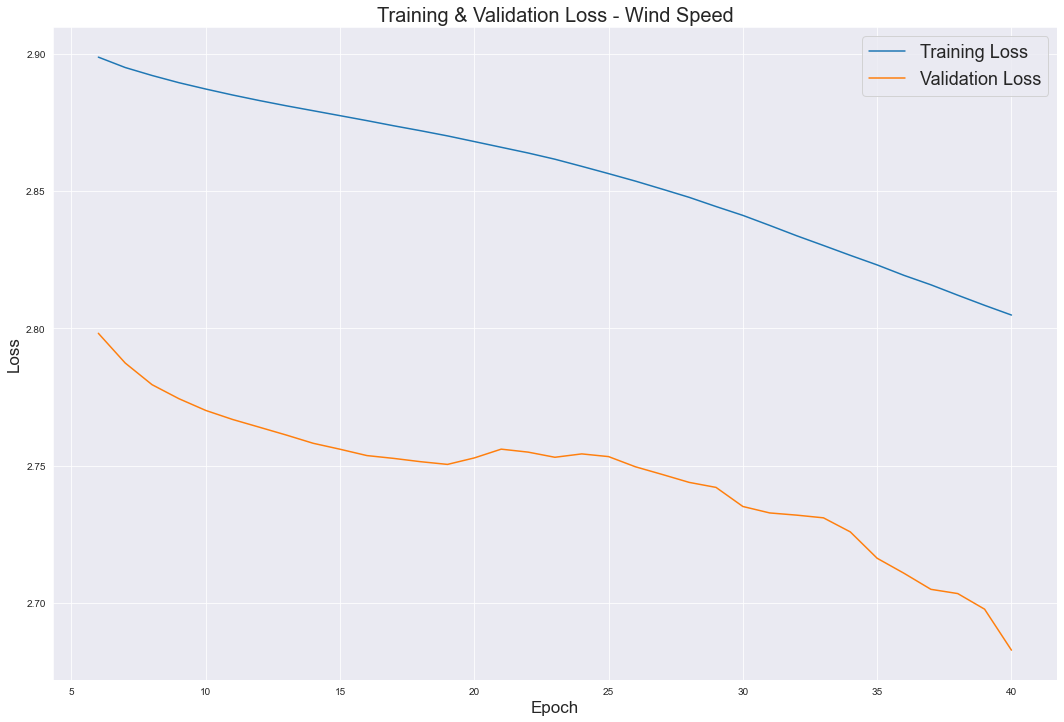

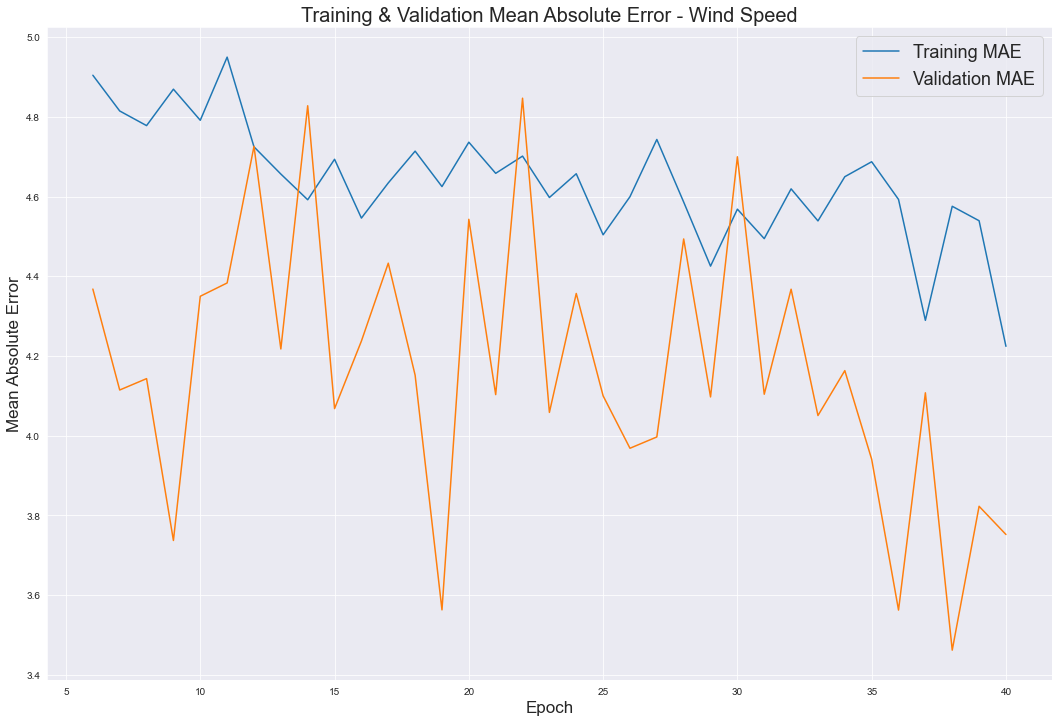

Final mean absolute error on training data:  4.224

Final mean absolute error on testing data:  3.752


In [19]:
start_point = 5

wind_loss = wind_hist['loss'][start_point:]
wind_mae = wind_hist['mae'][start_point:]

val_wind_loss = wind_hist['val_loss'][start_point:]
val_wind_mae = wind_hist['val_mae'][start_point:]

epoch = np.arange(1,epochs+1,1)[start_point:]

final_wind_mae = round(wind_mae[-1],3)
final_val_wind_mae = round(val_wind_mae[-1],3)

plt.figure(figsize=figsize)
plt.plot(epoch,wind_loss)
plt.plot(epoch,val_wind_loss)
plt.title('Training & Validation Loss - Wind Speed',fontdict={'fontsize':20})
plt.xlabel('Epoch',fontdict={'fontsize':17})
plt.ylabel('Loss',fontdict={'fontsize':17})
plt.legend(['Training Loss','Validation Loss'],prop={'size':18})
plt.show()

plt.figure(figsize=figsize)
plt.plot(epoch,wind_mae)
plt.plot(epoch,val_wind_mae)
plt.title('Training & Validation Mean Absolute Error - Wind Speed',fontdict={'fontsize':20})
plt.xlabel('Epoch',fontdict={'fontsize':17})
plt.ylabel('Mean Absolute Error',fontdict={'fontsize':17})
plt.legend(['Training MAE','Validation MAE'],prop={'size':18})
plt.show()

print('Final mean absolute error on training data: ',final_wind_mae)
print('\nFinal mean absolute error on testing data: ',final_val_wind_mae)

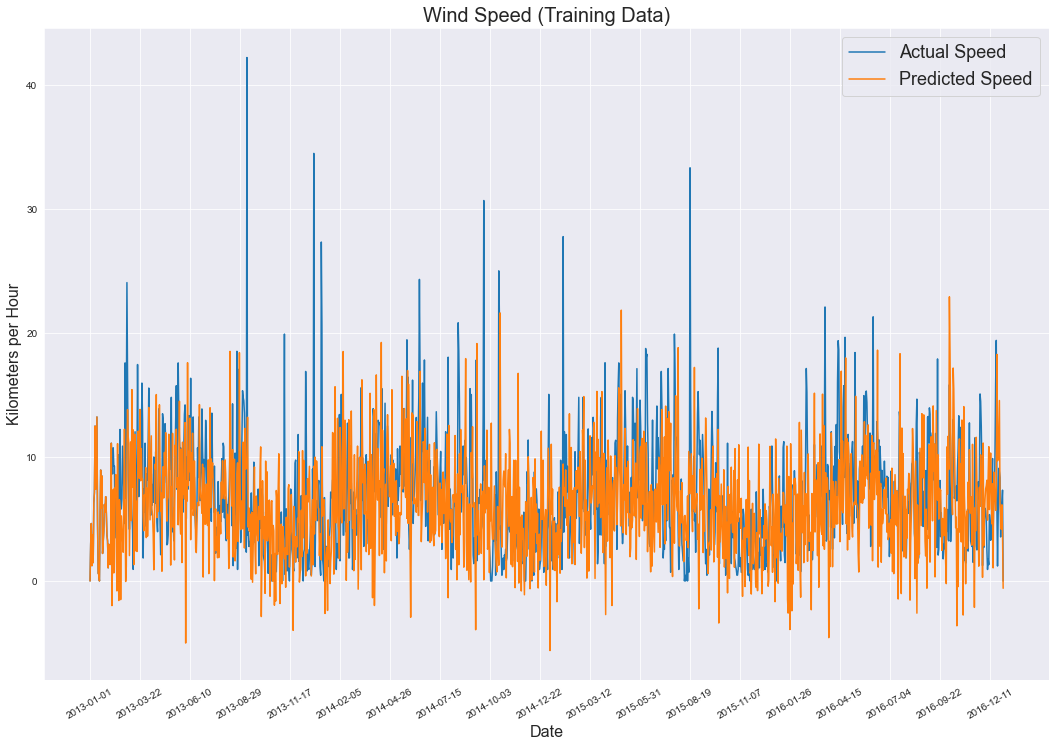

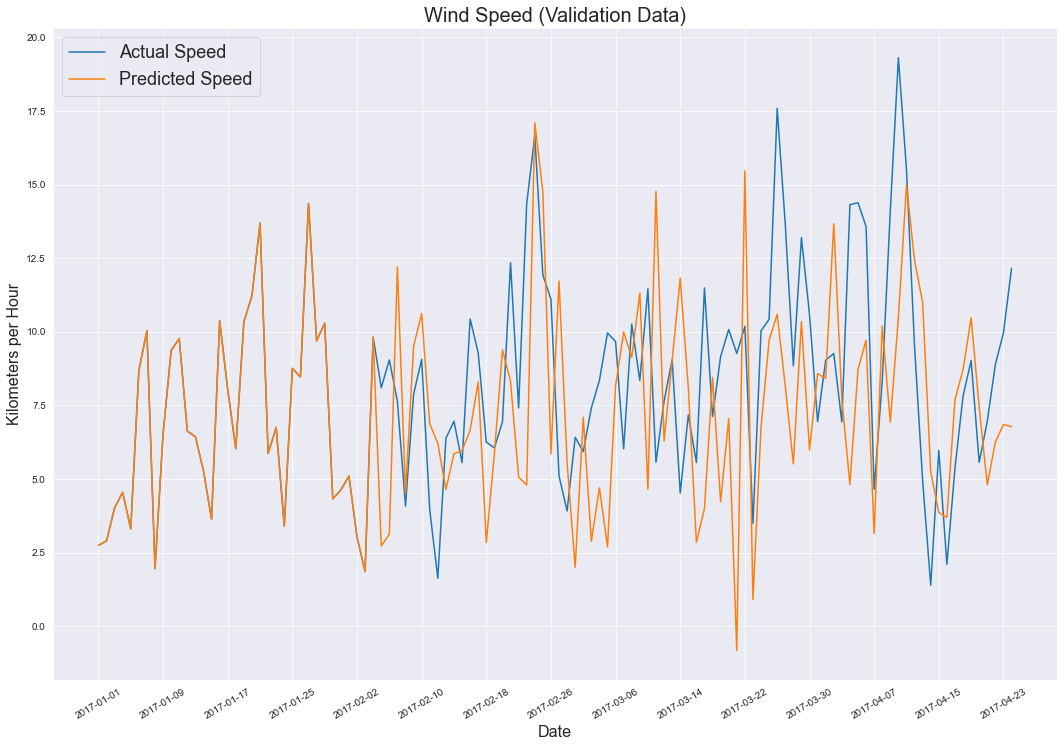

In [20]:
train_wind_predictions = wind_model.predict(train_wind_speed)
train_wind_predictions = np.hstack([train_data['wind_speed'][:windspeed_window_size-1],
                                        train_wind_predictions.squeeze()])

test_wind_predictions = wind_model.predict(test_wind_speed)
test_wind_predictions = np.hstack([test_data['wind_speed'][:windspeed_window_size-1],
                                       test_wind_predictions.squeeze()])

test_idx = np.array(test_data.index)
test_idx = test_data['date'][test_idx%8==0]

plt.figure(figsize=figsize)
sns.lineplot(data=train_data,x='date',y='wind_speed')
sns.lineplot(x=train_data['date'],y=train_wind_predictions)
plt.xlabel('Date',fontdict={'fontsize':16})
plt.title('Wind Speed (Training Data)',fontdict={'fontsize':20})
plt.ylabel('Kilometers per Hour',fontdict={'fontsize':16})
plt.legend(['Actual Speed','Predicted Speed'],prop={'size':18})
plt.xticks(idx,rotation=30)
plt.show()

plt.figure(figsize=figsize)
sns.lineplot(data=test_data,x='date',y='wind_speed')
sns.lineplot(x=test_data['date'],y=test_wind_predictions)
plt.xlabel('Date',fontdict={'fontsize':16})
plt.title('Wind Speed (Validation Data)',fontdict={'fontsize':20})
plt.ylabel('Kilometers per Hour',fontdict={'fontsize':16})
plt.legend(['Actual Speed','Predicted Speed'],prop={'size':18})
plt.xticks(test_idx,rotation=30)
plt.show()

In [21]:
air_pressure_window_size = 41

train_air_pressure = make_dataset(train_data,'meanpressure',air_pressure_window_size)
test_air_pressure = make_dataset(test_data,'meanpressure',air_pressure_window_size)

In [22]:
l1 = keras.regularizers.L1(.01)
l2 = keras.regularizers.L2(.01)
dropout_rate = .1

air_model = keras.Sequential([
    keras.layers.Lambda(lambda sequence: tf.expand_dims(sequence,axis=-1),input_shape=(air_pressure_window_size-1,)),
    keras.layers.GRU(150,activation='elu',return_sequences=True),
    keras.layers.GRU(150,activation='elu',return_sequences=True),
    keras.layers.GRU(150,activation='relu'),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.RMSprop(learning_rate=1e-4,
                                    momentum=.9)

air_model.compile(loss='huber',
                 optimizer=optimizer,
                 metrics='mae')

air_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_4 (Lambda)            (None, 40, 1)             0         
_________________________________________________________________
gru_2 (GRU)                  (None, 40, 150)           68850     
_________________________________________________________________
gru_3 (GRU)                  (None, 40, 150)           135900    
_________________________________________________________________
gru_4 (GRU)                  (None, 150)               135900    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 151       
Total params: 340,801
Trainable params: 340,801
Non-trainable params: 0
_________________________________________________________________


In [23]:
epochs = 50

def schedule(epoch,learning_rate):
    if epoch in [epochs/2,epochs*3/4]:
        learning_rate = learning_rate/10
    return learning_rate

lr_scheduler = keras.callbacks.LearningRateScheduler(schedule,
                                                    verbose=0)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_mae',
                                              patience=25,
                                              restore_best_weights=True)
        

air_history = air_model.fit(train_air_pressure,
                           validation_data=test_air_pressure,
                           epochs=epochs,
                           verbose=False,
                           callbacks=[lr_scheduler,
                                     early_stopping])

air_hist = air_history.history

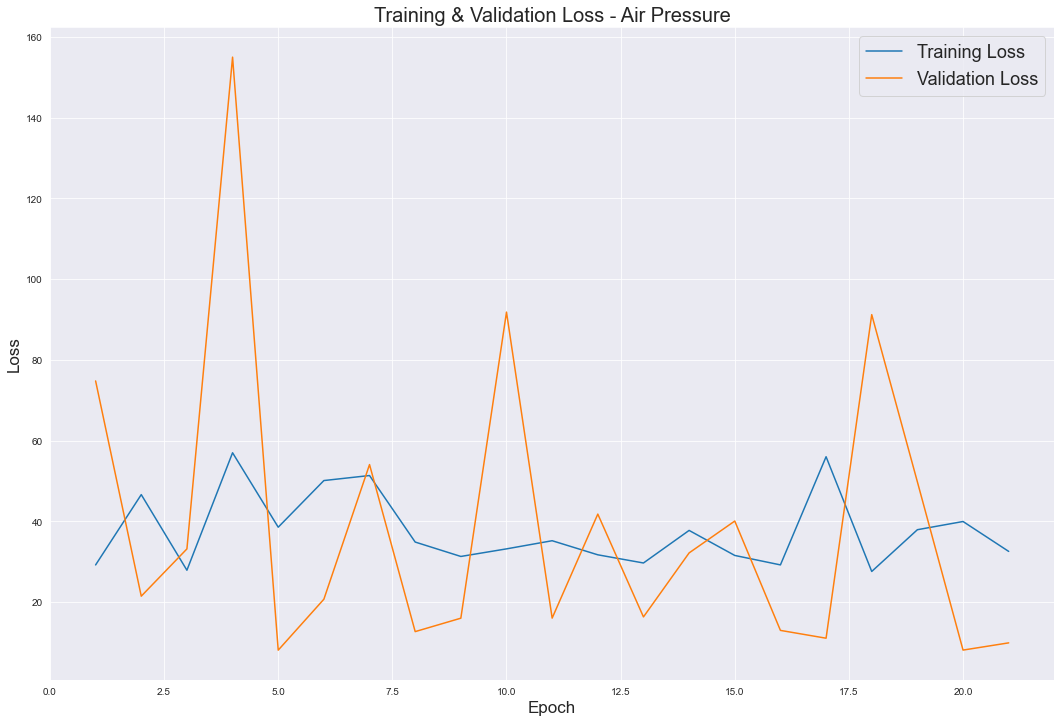

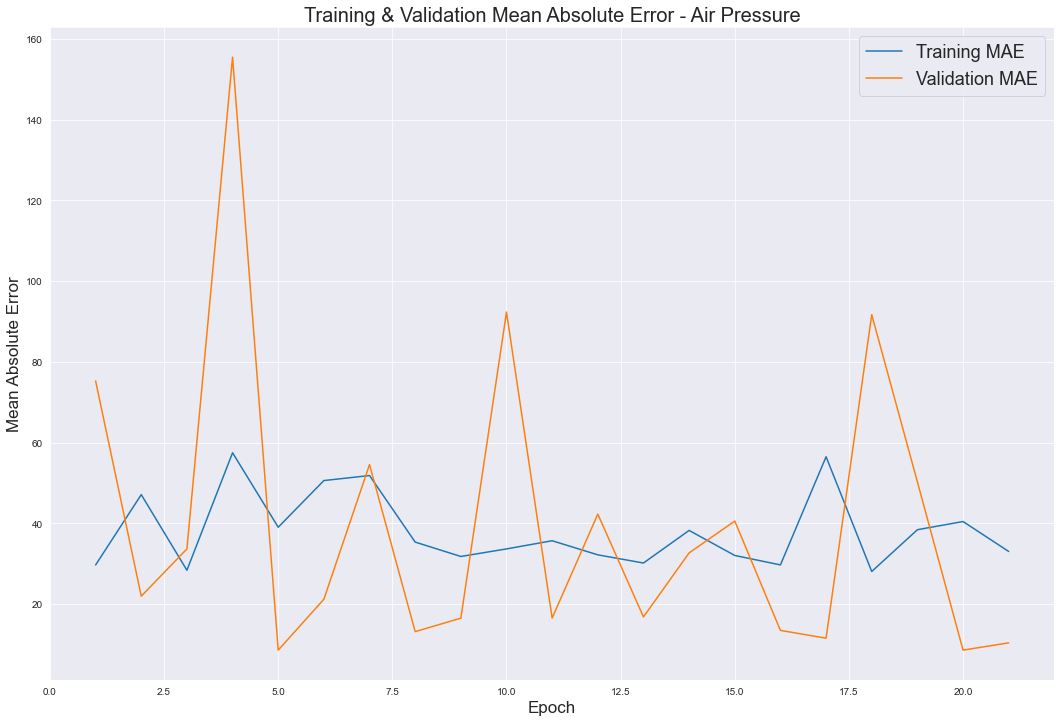

Final mean absolute error on training data:  33.03

Final mean absolute error on testing data:  10.391


In [24]:
start_point = 5

air_loss = air_hist['loss'][start_point:]
air_mae = air_hist['mae'][start_point:]

val_air_loss = air_hist['val_loss'][start_point:]
val_air_mae = air_hist['val_mae'][start_point:]

epoch = np.arange(1,len(air_loss)+1)

final_air_mae = round(air_mae[-1],3)
final_val_air_mae = round(val_air_mae[-1],3)

plt.figure(figsize=figsize)
plt.plot(epoch,air_loss)
plt.plot(epoch,val_air_loss)
plt.title('Training & Validation Loss - Air Pressure',fontdict={'fontsize':20})
plt.xlabel('Epoch',fontdict={'fontsize':17})
plt.ylabel('Loss',fontdict={'fontsize':17})
plt.legend(['Training Loss','Validation Loss'],prop={'size':18})
plt.show()

plt.figure(figsize=figsize)
plt.plot(epoch,air_mae)
plt.plot(epoch,val_air_mae)
plt.title('Training & Validation Mean Absolute Error - Air Pressure',fontdict={'fontsize':20})
plt.xlabel('Epoch',fontdict={'fontsize':17})
plt.ylabel('Mean Absolute Error',fontdict={'fontsize':17})
plt.legend(['Training MAE','Validation MAE'],prop={'size':18})
plt.show()

print('Final mean absolute error on training data: ',final_air_mae)
print('\nFinal mean absolute error on testing data: ',final_val_air_mae)

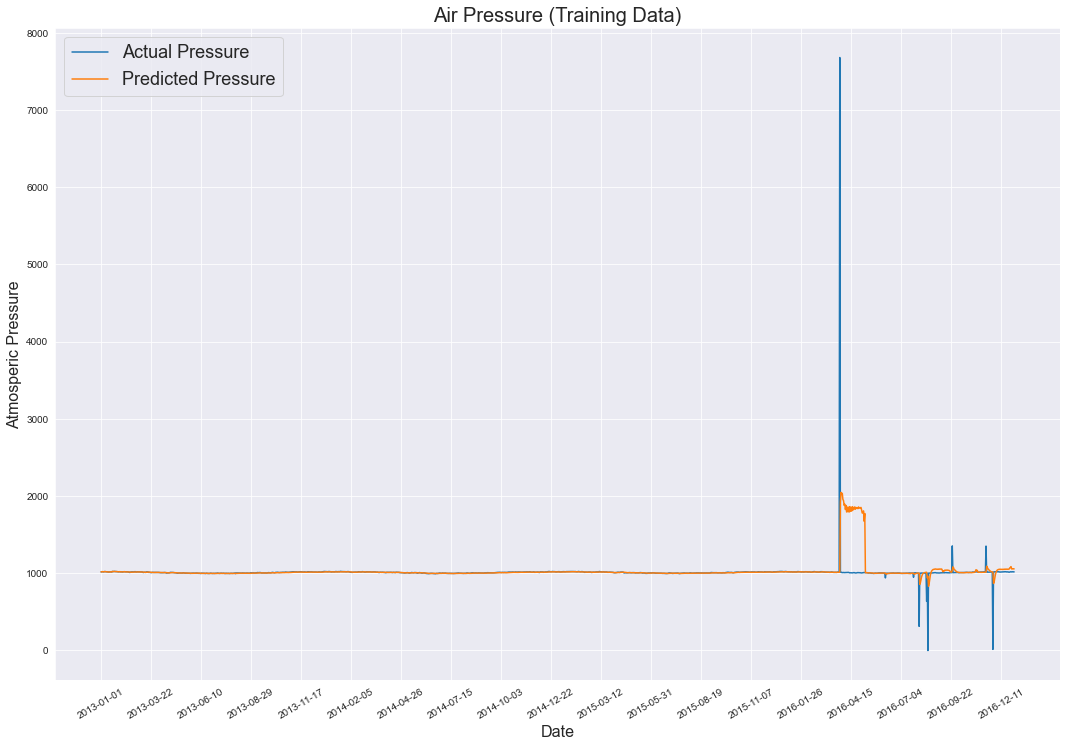

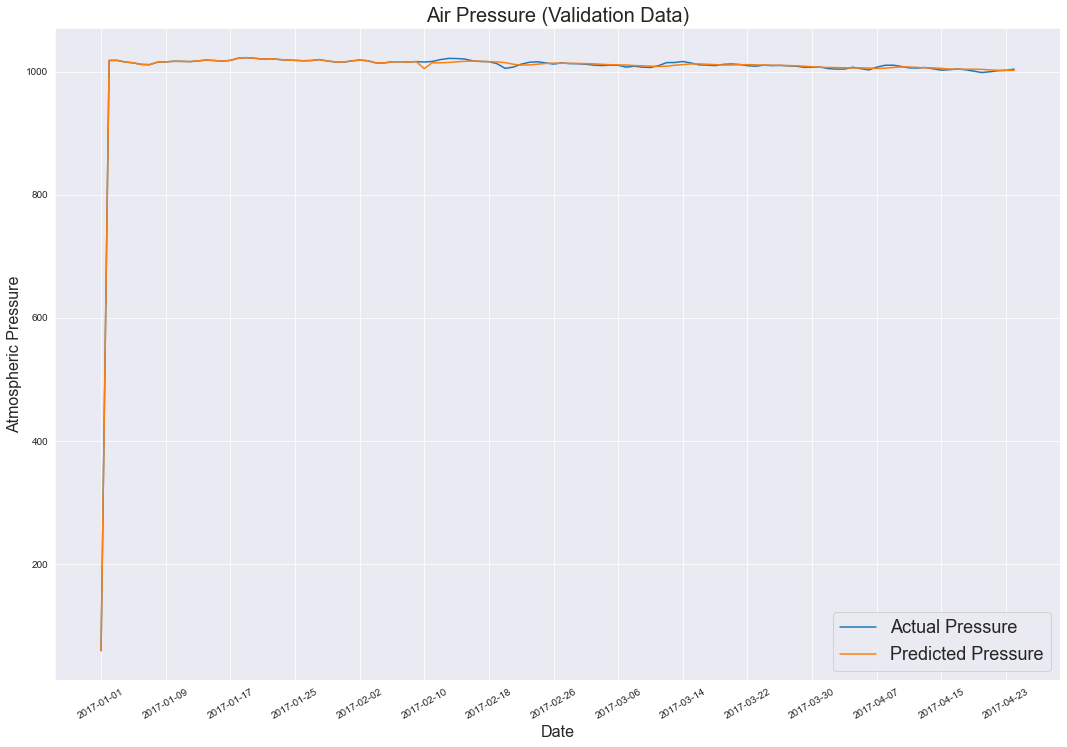

In [25]:
train_air_predictions = air_model.predict(train_air_pressure)
train_air_predictions = np.hstack([train_data['meanpressure'][:air_pressure_window_size-1],
                                        train_air_predictions.squeeze()])

test_air_predictions = air_model.predict(test_air_pressure)
test_air_predictions = np.hstack([test_data['meanpressure'][:air_pressure_window_size-1],
                                       test_air_predictions.squeeze()])

test_idx = np.array(test_data.index)
test_idx = test_data['date'][test_idx%8==0]

plt.figure(figsize=figsize)
sns.lineplot(data=train_data,x='date',y='meanpressure')
sns.lineplot(x=train_data['date'],y=train_air_predictions)
plt.xlabel('Date',fontdict={'fontsize':16})
plt.title('Air Pressure (Training Data)',fontdict={'fontsize':20})
plt.ylabel('Atmosperic Pressure',fontdict={'fontsize':16})
plt.legend(['Actual Pressure','Predicted Pressure'],prop={'size':18})
plt.xticks(idx,rotation=30)
plt.show()

plt.figure(figsize=figsize)
sns.lineplot(x=test_data['date'],y=test_data['meanpressure'])
sns.lineplot(x=test_data['date'],y=test_air_predictions)
plt.xlabel('Date',fontdict={'fontsize':16})
plt.title('Air Pressure (Validation Data)',fontdict={'fontsize':20})
plt.ylabel('Atmospheric Pressure',fontdict={'fontsize':16})
plt.legend(['Actual Pressure','Predicted Pressure'],prop={'size':18})
plt.xticks(test_idx,rotation=30)
plt.show()